### Preparation:

In [1]:
pwd()

"/home/zyu20/git/BulkLMM.jl/test/notebooks"

In [2]:
cd("..")

In [3]:
Threads.nthreads()

24

In [4]:
include("BXDdata_for_test.jl"); ## Load BXD data used for testing:

In [39]:
using LoopVectorization
using Plots

In [6]:
include("../src/scan_LiteQTL.jl"); ## Load multithreaded functions to be tested:

In [7]:
include("../src/parallel_helpers.jl");

In [11]:
kinship_Gc = CSV.read("run-gemma/output/kinship.cXX.txt", DataFrame, delim = '\t', header = false) |> Matrix;

### Compute null hsqs for every trait:

In [24]:
BLAS.set_num_threads(1)

In [50]:
function get_hsqs_from_null(Y::Array{Float64, 2}, K::Array{Float64, 2}; reml::Bool = true)

    (n, m) = size(Y);
    intercept = reshape(ones(n, 1), :, 1);
    (Y0, intercept0, lambda0) = rotateData(Y, intercept, K);
    
    hsqs_from_null = Array{Float64, 1}(undef, m);
    
    for i in 1:m
        
        y0_i = reshape(Y0[:, i], :, 1);
        out00 = fitlmm(y0_i, intercept0, lambda0; reml = reml);
        hsqs_from_null[i] = out00.h2;
        
    end
    
    return hsqs_from_null;
    
end

get_hsqs_from_null (generic function with 1 method)

In [51]:
@time hsqs_from_null = get_hsqs_from_null(pheno, kinship_Gc; reml = true);

 11.494934 seconds (31.89 M allocations: 12.694 GiB, 13.24% gc time)


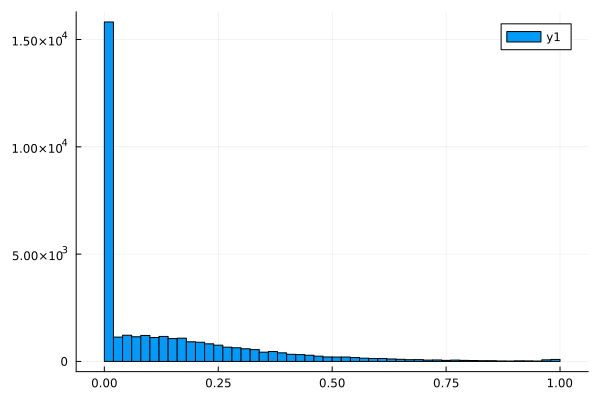

In [52]:
histogram(hsqs_from_null)

In [42]:
findall(hsqs_from_null .> 0.90)

239-element Vector{Int64}:
   536
   712
  1292
  1558
  1634
  2571
  2886
  3069
  3268
  3403
  3446
  3745
  3950
     ⋮
 32890
 32955
 33026
 33160
 33310
 33458
 34153
 34344
 34507
 34735
 34766
 35268

In [43]:
hsqs_from_null[7919]

0.8182834272313365

### Compute LOD scores from scan_alt:

In [59]:
function get_LODs_from_alt(Y::Array{Float64, 2}, G::Array{Float64, 2}, K::Array{Float64, 2}; reml::Bool = false)

    (n, m) = size(Y);
    p = size(G, 2);
    
    intercept = reshape(ones(n, 1), :, 1);
    (Y0, X0, lambda0) = rotateData(Y, [intercept G], K);
    
    lods_from_alt = Array{Float64, 2}(undef, p, m);
    hsqs_from_alt = Array{Float64, 2}(undef, p, m);

    intercept0 = reshape(X0[:, 1], :, 1);
    
    for i in 1:m
        
        y0_i = reshape(Y0[:, i], :, 1);
        out00 = fitlmm(y0_i, intercept0, lambda0; reml = reml);
        
        lod = zeros(p);
        hsqs = zeros(p);
        X = zeros(n, 2);
        X[:, 1] = X0[:, 1];
        
        for j in 1:p
            X[:, 2] = X0[:, j+1];
            
            out11 = fitlmm(y0_i, X, lambda0; reml = reml);
            
            hsqs[j] = out11.h2;
            lod[j] = (out11.ell - out00.ell)/log(10);
            
        end
        
        lods_from_alt[:, i] = lod;
        hsqs_from_alt[:, i] = hsqs;
        
    end
    
    return (hsqs_from_alt, lods_from_alt);
    
end

get_LODs_from_alt (generic function with 1 method)

In [ ]:
@time results_from_alt = get_LODs_from_alt(pheno, geno, kinship_Gc; reml = false);

In [ ]:
writedlm("hsqs_from_alt.csv", results_from_alt[1], ',');

In [ ]:
writedlm("lods_from_alt.csv", results_from_alt[2], ',');

### Compute LOD scores from GEMMA:

In [107]:
@time bulkscan_LODs = bulkscan(pheno, geno, kinship_Gc, hsq_list);

2020.285007 seconds (338.30 k allocations: 3.394 TiB, 6.46% gc time)


In [13]:
gemma = "/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64";

In [14]:
gemma_results = readdlm("run-gemma/output/gemma_results.txt.assoc.txt", '\t');

In [72]:
gemma_results

7322×10 Matrix{Any}:
   "chr"  "rs"             "ps"  …     "logl_H1"   "l_mle"   "p_lrt"
 -9       "rs31443144"   -9         -48.1777      1.0e6     0.968104
 -9       "rs6269442"    -9         -48.1777      1.0e6     0.968104
 -9       "rs32285189"   -9         -48.1777      1.0e6     0.968104
 -9       "rs258367496"  -9         -48.1777      1.0e6     0.968104
 -9       "rs32430919"   -9      …  -48.1777      1.0e6     0.968104
 -9       "rs36251697"   -9         -48.1777      1.0e6     0.968104
 -9       "rs30658298"   -9         -48.1777      1.0e6     0.968104
 -9       "rs51852623"   -9         -48.1777      1.0e6     0.968104
 -9       "rs31879829"   -9         -48.1777      1.0e6     0.968104
 -9       "rs36742481"   -9      …  -48.1777      1.0e6     0.968104
 -9       "rs6365999"    -9         -48.1777      1.0e6     0.968104
 -9       "rs13470446"   -9         -48.1777      1.0e6     0.968111
  ⋮                              ⋱                          
 -9       "rs31466210

In [108]:
function p2lod(pval::Float64, df::Int64)
    
    lrs = invlogcdf(Chisq(df), log(1-pval))
    lod = lrs/(2*log(10))
    
    # return lrs
    return lod

end

p2lod (generic function with 1 method)

In [109]:
traitID = 7919;

In [110]:
gemma_LODs = map(x -> p2lod(x, 1), gemma_results[2:end, 10]);

In [111]:
hcat(gemma_LODs, bulkscan_LODs[:, traitID])

7321×2 Matrix{Float64}:
 0.000347201  0.00817418
 0.000347201  0.00817418
 0.000347201  0.00817418
 0.000347201  0.00817418
 0.000347201  0.00817418
 0.000347201  0.00817418
 0.000347201  0.00817418
 0.000347201  0.00817418
 0.000347201  0.00817418
 0.000347201  0.00817418
 0.000347201  0.00817418
 0.000347048  0.00817308
 0.0136122    0.0796135
 ⋮            
 0.34953      0.346613
 0.34953      0.346613
 0.34953      0.346613
 0.15078      0.149648
 5.71076e-5   0.100278
 5.71076e-5   0.100278
 0.00038703   0.122454
 0.00241117   0.156015
 0.00212054   0.152455
 0.00567567   0.187083
 0.00289181   0.152502
 0.00289181   0.152502

In [112]:
scan_null_lod = scan_null(reshape(pheno[:, traitID], :, 1), geno, kinship_Gc; reml = true);

In [113]:
scan_alt_lod = scan_alt(reshape(pheno[:, traitID], :, 1), geno, kinship_Gc; reml = false);

In [114]:
scan_null_lod[1:2]

(0.27014442507297315, 0.8182834272134801)

In [115]:
scan_alt_lod[1:2]

(0.27093129114871545, 0.8398237254127265)

In [116]:
pve_list = scan_alt_lod[3]

7321-element Vector{Float64}:
 0.8393761715161548
 0.839376171906808
 0.8393761715158412
 0.8393761715158412
 0.8393761543085021
 0.8393761841216929
 0.8393761716135127
 0.8393761716135127
 0.8393761717117171
 0.8393761717117171
 0.8393761719122176
 0.8393762253161536
 0.8395948794111346
 ⋮
 0.8510219677978855
 0.8510219677922489
 0.8510219677922489
 0.8447188147735921
 0.8386195836198566
 0.8386195836198566
 0.8381506264733634
 0.8371840449155191
 0.8372896306294759
 0.8362295109563406
 0.8376078862214319
 0.8376078862214319

In [120]:
hcat(gemma_LODs, scan_null_lod[3], scan_alt_lod[4], bulkscan_LODs[:, traitID])

7321×4 Matrix{Float64}:
 0.000347201  0.00783497  0.00753141  0.00817418
 0.000347201  0.00783497  0.00753141  0.00817418
 0.000347201  0.00783497  0.00753141  0.00817418
 0.000347201  0.00783497  0.00753141  0.00817418
 0.000347201  0.00783497  0.00753141  0.00817418
 0.000347201  0.00783497  0.00753141  0.00817418
 0.000347201  0.00783497  0.00753141  0.00817418
 0.000347201  0.00783497  0.00753141  0.00817418
 0.000347201  0.00783497  0.00753141  0.00817418
 0.000347201  0.00783497  0.00753141  0.00817418
 0.000347201  0.00783497  0.00753141  0.00817418
 0.000347048  0.00783393  0.00753041  0.00817308
 0.0136122    0.00979026  0.00957543  0.0796135
 ⋮                                    
 0.34953      0.0949866   0.111349    0.346613
 0.34953      0.0949866   0.111349    0.346613
 0.34953      0.0949866   0.111349    0.346613
 0.15078      0.0124035   0.0180153   0.149648
 5.71076e-5   0.00756242  0.0062785   0.100278
 5.71076e-5   0.00756242  0.0062785   0.100278
 0.00038703   0.014

In [121]:
typeof(maxSqDiff(reshape(gemma_LODs, :, 1), reshape(bulkscan_LODs[:, traitID], :, 1)))

Float64

In [122]:
sumSqDiff(reshape(gemma_LODs, :, 1), reshape(bulkscan_LODs[:, traitID], :, 1))

Inf

In [123]:
maxSqDiff(reshape(scan_alt_lod[4], :, 1), reshape(bulkscan_LODs[:, traitID], :, 1))

39.50243022951081

In [124]:
sumSqDiff(reshape(scan_alt_lod[4], :, 1), reshape(bulkscan_LODs[:, traitID], :, 1))

2859.243040916997

In [126]:
diff = bulkscan_LODs[:, traitID] .- scan_alt_lod[4]

7321-element Vector{Float64}:
 0.000642773240984133
 0.0006427732409748756
 0.0006427732409798664
 0.0006427732409798664
 0.000642773240987219
 0.000642773240987219
 0.0006427732409798664
 0.0006427732409798664
 0.0006427732409829516
 0.0006427732409829516
 0.0006427732307979174
 0.0006426629587205157
 0.07003802748767592
 ⋮
 0.235264401563465
 0.2352644013563317
 0.2352644013563317
 0.1316324110601118
 0.09399960211397712
 0.09399960211397712
 0.11010784644509328
 0.13036417399371159
 0.12839907637421188
 0.14572937131025138
 0.14245612059728235
 0.14245612059728235

In [127]:
sum(diff .> 0)

7204

In [66]:
findmax(diff)

(Inf, 386)

In [67]:
gemma_LODs[386]

Inf

In [68]:
bulkscan_LODs[386]

0.030859579577579805

In [60]:
sqDiff = diff.^2

7321-element Vector{Float64}:
 5.1442402969603324e-5
 5.1442402969603324e-5
 5.1442402969603324e-5
 5.1442402969603324e-5
 5.1442402969603324e-5
 5.1442402969603324e-5
 5.144240296963066e-5
 5.144240296963066e-5
 5.1442402969603324e-5
 5.1442402969603324e-5
 5.1442401651732605e-5
 5.143031791056806e-5
 1.655814872496203e-5
 ⋮
 0.05902232376905036
 0.05902232393621647
 0.05902232393621647
 0.017870370608174414
 3.772787996126475e-5
 3.772787996126475e-5
 0.0001390610231513959
 0.0005214785550989552
 0.000464897623431067
 0.0012224535229324138
 4.8548144840955944e-5
 4.8548144840955944e-5